In [4]:
import praw
import csv
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams,ngrams
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import string 
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
from sklearn import preprocessing
import wordcloud

In [5]:
#reads in depressed data
depressed_df = pd.read_csv('depressed_comments.csv', delimiter = ',')

#sets label and column
depressed_df.columns = ['text']
depressed_df['label'] = 1

#reads in non-depressed data and resizes to match depressed
non_depress_df = pd.read_csv('non_depressed_comments.csv', delimiter = ',')[:len(depressed_df)]

#shuffles the data
non_depress_df = shuffle(non_depress_df).reset_index(drop = True)

#sets label and column
non_depress_df.columns = ["text"]
non_depress_df['label'] = 0

#combines non-depressed and depressed data and shuffles
df = pd.concat([depressed_df,non_depress_df])
df = shuffle(df).reset_index(drop = True)




In [6]:
df.shape

(44636, 2)

In [84]:
lemmatizer = WordNetLemmatizer()
stoplist = set(stopwords.words('english') + list(string.punctuation))    
whitelist = ["not","no","few"]    
tokenizer = TweetTokenizer(reduce_len = True)
[stoplist.remove(word) for word in whitelist]


def clean_data(df):
    #using regular expressions, cleans out hashtags, @ marks, strings with digits, and repeated periods.
    regex = re.compile(r"([@#_])|(\d+)|(\.{2,})")
    df["text"] = df["text"].str.replace(regex, '')
    df["text"] = df["text"].apply(lambda row: str(row))
    df.dropna(subset=['text'])
    return df

#preprocess functions
def preprocess(df,ngram):
    #tokenized 
    def tokenize_row(row):
        if type(row["text"]) is str:
            row["text"] = tokenizer.tokenize(row["text"].lower())
        return row
    df = df.apply(tokenize_row, axis =1 )
    #lemmatized
    df["text"] = df["text"].apply(lambda x:[lemmatizer.lemmatize(y) for y in x])
    df["text"] = df["text"].apply(lambda x: [y for y in x if y not in stoplist])
    df["text"] = df["text"].apply(lambda x: list(ngrams(x,ngram)))
    return df

#create frequency list
def build_wordlist(df):
    words = Counter()
    for index in df.index:
        words.update(df.loc[index,'text'])
        
    freq_df = pd.DataFrame(data = {"word":[word for word,count in words.most_common(100)],
                                   "frequency":[count for word,count in words.most_common(100)]}, 
                          columns = ["word","frequency"])        
    return freq_df  

def graph_tot_freq(df,title):
    graph = df.plot.barh(figsize = (10,8))
    graph.set_yticklabels(df["word"])
    graph.invert_yaxis()
    graph.set_title(title)
    

def build_word_cloud(wordlist, color, title):
    subset = wordlist[["word","frequency"]]
    subset["word"] = subset["word"].apply(lambda x: ' '.join(x))
    wordlist_tuples = dict(x for x in subset.values)
    wc = WordCloud(max_words = 100, background_color = color,width = 1000, height = 750).fit_words(wordlist_tuples)
    plt.figure(figsize = (10,10))
    plt.imshow(wc)
    plt.title(title)
    plt.axis("off")    
    plt.show()
    
    
#create bag of words vector
def bag_of_words(data):
    #creates a bag of words vector and normalizes it by inverse document frequency
    count_vect = TfidfVectorizer(sublinear_tf = True, norm='l2',analyzer = lambda x:x, lowercase = False)    
    X_vect = count_vect.fit_transform(data["text"])
    return X_vect, count_vect
    
    ''' doing from scratch VERY VERY SLOW
    column = ["label"]
    labels = data["label"]
    columns = list(map(lambda x:x, wordlist_df["word"]))
    
    rows = []
    for index in data.index:
        cur_row = []
        tokens = list(data.loc[index,"text"])
        for row in wordlist.itertuples():
            cur_row.append(1 if row.word in tokens else 0)
            
        rows.append(cur_row)
        
    return pd.DataFrame(data = rows)'''
  
def classifier(X,y,models,split):
    predictions = []
    split = split
    for name, model in models:    
        kfold = KFold(n_splits = split,shuffle = True, random_state = 10)
        predicted = cross_val_predict(model,X, y, cv=kfold)
        predictions.append((name,predicted))
    for name, predicted in predictions:
        print("----------------------------------------------------------------")
        print("%s with %d fold Cross-validation"%(name,split))
        print("Accuracy: %s:" %metrics.accuracy_score(y, predicted))
        print("Average accuracy: %.4f (%.4f)" %(metrics.accuracy_score(y, predicted).mean(),metrics.accuracy_score(y, predicted).std()))
        print("f1: %s:" %metrics.f1_score(y, predicted))
        print("Average f1: %.4f (%.4f)" %(metrics.f1_score(y, predicted).mean(),metrics.f1_score(y, predicted).std()))
        print("Precision: %s:" %metrics.precision_score(y, predicted))
        print("Average precision: %.4f (%.4f)" %(metrics.precision_score(y, predicted).mean(),metrics.precision_score(y, predicted).std()))   
        print("Recall: %s:" %metrics.recall_score(y, predicted))
        print("Average recall: %.4f (%.4f)" %(metrics.recall_score(y, predicted).mean(),metrics.recall_score(y, predicted).std()))          
        print("----------------------------------------------------------------")
    return predictions

def graph_roc_curve(predictions_list,y):
    plt.figure(figsize = (8,6))
    for name,pred in predictions_list:
        fpr = []
        tpr = []
        roc_auc = []        
        fpr,tpr,threshold = metrics.roc_curve(y,pred)
        roc_auc = metrics.auc(fpr,tpr)
        plt.plot(fpr,tpr,color = np.random.rand(3,),label = "%s (%.2f)" %(name,roc_auc))
    plt.title("ROC Curve")
    plt.plot([0.0,1.0],[0.0,1.0],color = 'black', linestyle = "--")
    plt.xlim([0.0,1.0])
    plt.legend(loc = "lower right")
    plt.ylabel("True Positive")
    plt.xlabel("False Positive")
    
    

In [95]:
depressed_df_cleaned = clean_data(depressed_df)
depressed_df_processed_unigrams = preprocess(depressed_df_cleaned,1)
depressed_wordlist_unigrams = build_wordlist(depressed_df_processed_unigrams)

In [96]:
depressed_df_processed_bigrams = preprocess(depressed_df_cleaned,2)
depressed_wordlist_bigrams = build_wordlist(depressed_df_processed_bigram)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: generator 'ngrams' raised StopIteration


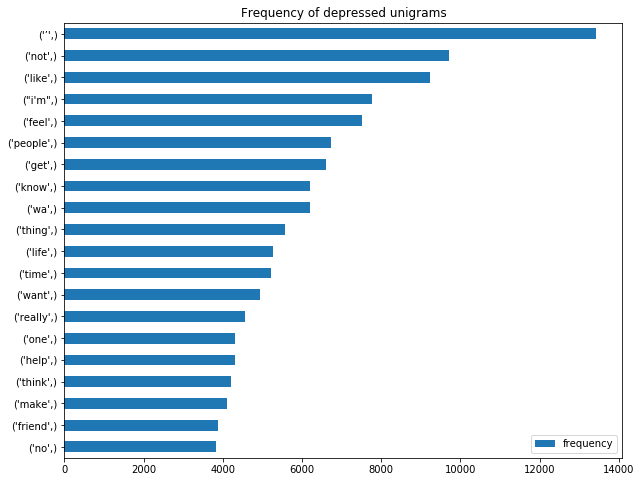

In [97]:
graph_tot_freq(depressed_wordlist_unigrams[:20], 'Frequency of depressed unigrams')

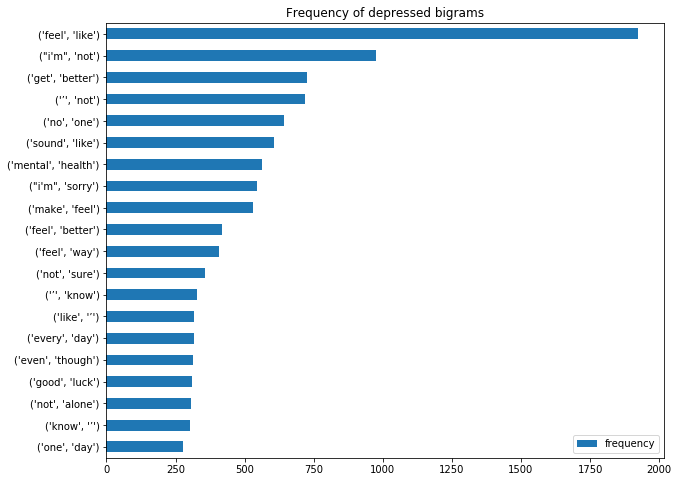

In [98]:
graph_tot_freq(depressed_wordlist_bigrams[:20], 'Frequency of depressed bigrams')

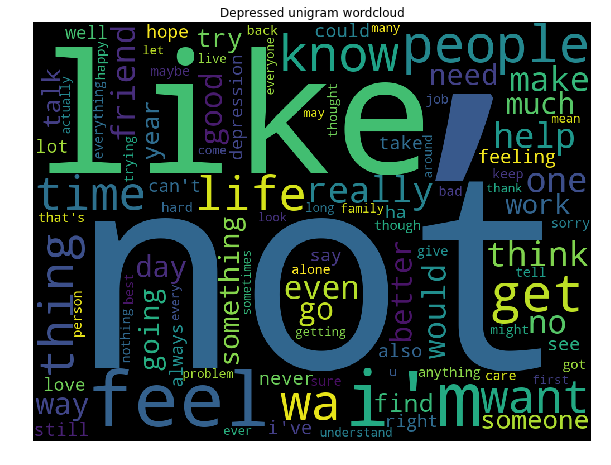

In [110]:
build_word_cloud(depressed_wordlist_unigrams,'black',"Depressed unigram wordcloud")

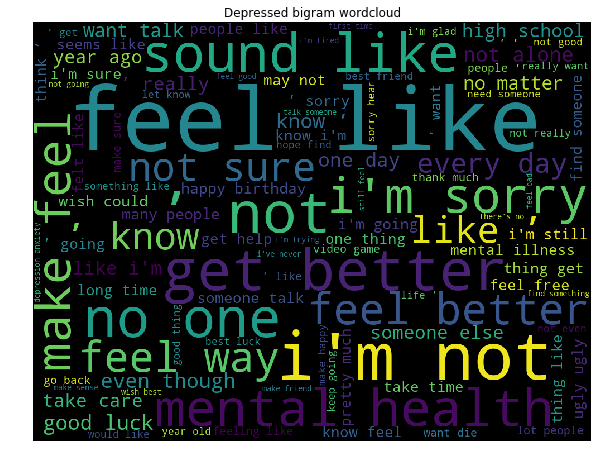

In [111]:
build_word_cloud(depressed_wordlist_bigrams,'black',"Depressed bigram wordcloud")

In [101]:
cleaned_df = clean_data(df)
preprocessed_df_unigrams = preprocess(cleaned_df,1)


In [102]:
preprocessed_df_bigrams = preprocess(cleaned_df,2)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: generator 'ngrams' raised StopIteration


In [112]:
X_vect_unigrams, count_vect_unigrams= bag_of_words(preprocessed_df_unigrams)
print(X_vect.shape)

(44636, 540582)


In [113]:
X_vect_bigrams, count_vect_bigrams= bag_of_words(preprocessed_df_bigrams)
print(X_vect.shape)

(44636, 540582)


In [114]:
models = [('Logistical Regression',LogisticRegression()),('Multinomial Naives Bayes',MultinomialNB())]
y= preprocessed_df_unigrams["label"]
X= X_vect_unigrams
df_predictions_unigrams=classifier(X,y,models,10)


----------------------------------------------------------------
Logistical Regression with 10 fold Cross-validation
Accuracy: 0.8365220897929923:
Average accuracy: 0.8365 (0.0000)
f1: 0.8702594100599186:
Average f1: 0.8703 (0.0000)
Precision: 0.8469924551810064:
Average precision: 0.8470 (0.0000)
Recall: 0.894840762002267:
Average recall: 0.8948 (0.0000)
----------------------------------------------------------------
----------------------------------------------------------------
Multinomial Naives Bayes with 10 fold Cross-validation
Accuracy: 0.808921050273322:
Average accuracy: 0.8089 (0.0000)
f1: 0.8616567452271657:
Average f1: 0.8617 (0.0000)
Precision: 0.7743280275202612:
Average precision: 0.7743 (0.0000)
Recall: 0.9711872463344181:
Average recall: 0.9712 (0.0000)
----------------------------------------------------------------


In [115]:
models = [('Logistical Regression',LogisticRegression()),('Multinomial Naives Bayes',MultinomialNB())]
y= preprocessed_df_bigrams["label"]
X= X_vect_bigrams
df_predictions_bigrams=classifier(X,y,models,10)

----------------------------------------------------------------
Logistical Regression with 10 fold Cross-validation
Accuracy: 0.701451742987723:
Average accuracy: 0.7015 (0.0000)
f1: 0.8015073879885606:
Average f1: 0.8015 (0.0000)
Precision: 0.6762259029331189:
Average precision: 0.6762 (0.0000)
Recall: 0.9837654027569563:
Average recall: 0.9838 (0.0000)
----------------------------------------------------------------
----------------------------------------------------------------
Multinomial Naives Bayes with 10 fold Cross-validation
Accuracy: 0.695335603548705:
Average accuracy: 0.6953 (0.0000)
f1: 0.800281975591488:
Average f1: 0.8003 (0.0000)
Precision: 0.6687447842521231:
Average precision: 0.6687 (0.0000)
Recall: 0.9962338659548795:
Average recall: 0.9962 (0.0000)
----------------------------------------------------------------


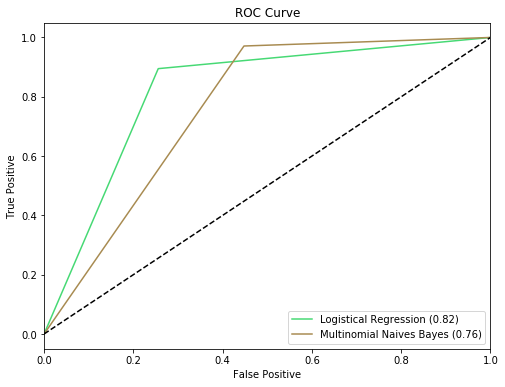

In [116]:
graph_roc_curve(df_predictions_unigrams,y)

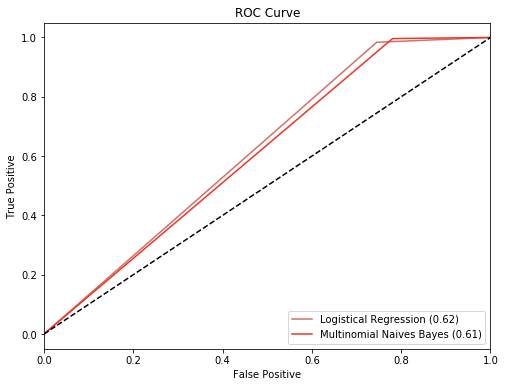

In [117]:
graph_roc_curve(df_predictions_bigrams,y)